# Notes

Next thing to work out is how to return reward so rllib doesn't return nan as output. Otherwise everything seems to be working as expected!


The game is currently returning 33 steps per 1 second.

It would be interesting to be able to record a video of one learning episode of the agent - look into how to do this (maybe ask around). - I can just save all the episode imgs into a folder, then use some app to play them all together and link to document.

Action selection with ppo seems to be messing up - look into this? currently ppo only returning nan rewards, as i think it is just choosing a direction then constantly moving that way. Maybe look at some rllib documentation for ppo or other implementations of it and check out the action spaces. 

### My wrapper for Light Game

In [ ]:
# !pip install gym

In [1]:
import gym
import random, math
import numpy as np
import arcade
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

        
# from LightEnvCopy import LightEnv
from LightEnvCopy import LightEnv

import gym.spaces
from gym.spaces import Discrete, Box

from ray.rllib.env.env_context import EnvContext
from ray.rllib.models import ModelCatalog

from collections import namedtuple

# Do the math to figure out our screen dimensions
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 600
SCREEN_TITLE = "Game 1: Let There Be Light!"

SPRITE_SCALING = 0.25

# How fast the camera pans to the player. 1.0 is instant.
CAMERA_SPEED = 0.1

PLAYER_MOVEMENT_SPEED = 7
BOMB_COUNT = 5
TORCH_COUNT = 1
PLAYING_FIELD_WIDTH = 800 #1600
PLAYING_FIELD_HEIGHT = 600 #1600
REWARD_COUNT = 1 #TF - Add in reward
END_GAME = False
torch_collected = False

#TF Start - Adding in actions for action conversion

# COnvenient data structure to hold information about actions
Action = namedtuple('Action', 'name index delta_i delta_j')

up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1)    

index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action
# print(index_to_actions[0].name)
str_to_actions = {}
for action in [up, down, left, right]:
    str_to_actions[action.name] = action
#TF End - Adding in actions for action conversion


class LightEnvWrapper(gym.Env, LightEnv):
    """Class that wraps the Lights Environment to make it 
    compatible with RLLib."""

    metadata = {"render.modes": ["rgb_array", "state_pixels"]}
    
    def __init__(self, config: EnvContext):
        super().__init__(SCREEN_WIDTH, SCREEN_HEIGHT, SCREEN_TITLE)
        self.counting = 0
#         game_size = config.get("size_env")

#         self.mygame = GUIWrapper(LightEnv)
        
        self.mygame = LightEnv
        #The action space is a choice of 9 actions: U/D/L/R/UR/DR/DL/UL/DO NOTHING. Not continuous
        #because speed of agent is fixed. Or potentially just 4: U/D/L/R.
        self.action_space = Discrete(4)
#         self.action_space = config.get("parrot_shriek_range", Discrete(4))
        #The observation space is a fixed image of the current game screen - fully observable.
        #Can set to a view just around the player using arcade.set_viewport.
        #Need obs space to be either 42,42,x or 84,84,x to be compatible with rllib.
        self.observation_space = Box(low=0, high=255, shape=(84,84, 4), dtype=np.uint8)
        
        self.counting = 0

    def reset(self):
        print("resetting in wrapper")
        self.render(drawing=True)
        #Resets the state of the environment for a new episode and an initial observation.
        obs_mygame = self.mygame.reset(self)
        
        #Open up the resetted image to verify working correctly.
        obs_mygame.show()
        
        #Convert observation to 84x84 resolution and np array for rllib.
        obs = self.convert_observations(obs_mygame)
        
#         print("resetted")
        return obs

    def step(self, action):
        self.counting += 1
#         print("Wrapper stepping number: ", self.counting) #every 33 is a second in game time.
#         print("stepping")
        #Choose a random action: 0, 1, 2, 3. Making sure only these 4 options chosen.
        assert action in [0, 1, 2, 3] #0-up,1-down,2-left,3-right.
        
        #Convert the numeric action to a keyword: up, down, left, right.
        actions_myenv = index_to_actions[action].name #returns a word, one of: up/down/left/right
        print(f"action taken: {actions_myenv}")
        
        #Update the window with on_update()
        self.render(self)
        
        #Compute observation extracted from the window (800x600), with reward and done flag.
        obs, reward, done = self.mygame.step(self,actions_myenv)
        
        if self.counting % 33 == 0:
#             print("self.counting is now divisible by 33(ie. 1 second has passed), showing obs now")
            print(f"total score is {self.score} at time: {self.mygame.time_taken_reported(self)}")
#             obs.show()

#         if self.mygame.time_taken_reported(self) % 100 == 0:
#             print(f"total score is {self.score} at time: {self.mygame.time_taken_reported(self)}")
            
#         print(f"step reward is {reward}")
        
        #Convert observation to 84x84 resolution and np array for rllib.
        obs_mygame = self.convert_observations(obs)
        
        #If the reward has been obtained, reset the environment and start again
        if done == True:
            print(f"done is {done}, resetting environment in wrapper.")
            self.reset()
        
#         print("Finished stepping")
        return obs_mygame, reward, done, {}

    def seed(self, seed=None):
        random.seed(seed)

    def convert_observations(self, obs_mygame): #Not needed? This is just for rescaling?
        # We normalize and concatenate observations
        obs = obs_mygame
        obs_resized = obs.resize((84,84))
        obsarray = np.array(obs_resized)
#         print("sum: ", np.sum(obsarray))
        return obsarray
    
    def render(self, mode='state_pixels', drawing=False):
        self.mygame.on_update(self, 1/60)
        self.mygame.on_draw(self)
        test = self.mygame.time_taken_reported(self)
#         print("testing time taken: ", test)
        

### Now run the rllib script to train the agent

In [ ]:
# !pip install ray==1.11.0
import gym
import ray.rllib.agents.ppo.ppo as ppo
from ray.rllib.algorithms.ppo import PPOConfig
from ray import air
from ray import tune
config = PPOConfig()


# import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print



from ray.rllib.algorithms.ppo import PPOConfig
config = PPOConfig().training(gamma=0.2, lr=0.1, kl_coeff=0.3)\
            .resources(num_gpus=0)\
            .rollouts(num_envs_per_worker=1, num_rollout_workers=1)
config.normalize_actions=False
config.env=LightEnvWrapper
config.framework='torch'
config.action_space=Discrete(4)
config.observation_space=Box(low=0, high=255, shape=(84,84, 4), dtype=np.uint8)
config.clip_actions=False
# config.env_config={"parrot_shriek_range": Discrete(5)}
print(config.to_dict())
# Build a Algorithm object from the config and run 1 training iteration.
trainer = config.build(env=LightEnvWrapper)
trainer.train()
# trainer = ppo.PPOTrainer(config=config)
# trainer.train()






# config = ppo.DEFAULT_CONFIG.copy()
# # config = dqn.DEFAULT_CONFIG.copy()
# config["preprocessor_pref"] = "rllib"
# config["num_workers"] = 0
# config["framework"] = "torch"
# # config["dueling"] = False
# # config["double_q"] = False
# config["env"] = LightEnvWrapper
# # config["env_config"] = { "size_env": 15}
# config["model"] = { "fcnet_hiddens": [64, 64],
#                     "fcnet_activation": "relu",
#     }

# trainer = ppo.PPOTrainer(config=config)
# trainer = dqn.DQNTrainer(config=config)

# Can optionally call trainer.restore(path) to load a checkpoint.

# avg_rewards = []
# num_iterations = []
# time_spent = []
# for episode in range(1000):
#     print("Starting episode ", episode)
#     # Perform one iteration of training the policy with PPO
#     result = trainer.train()
#     #print(pretty_print(result))
#     print("episode reward mean: ", result['episode_reward_mean'])
#     avg_rewards.append(result['episode_reward_mean'])
#     num_iterations.append(episode)
#     if episode % 10 == 0:
#         checkpoint = trainer.save()
#         print("checkpoint saved at", checkpoint)
#     print("End of episode ", episode)
    

{'extra_python_environs_for_driver': {}, 'extra_python_environs_for_worker': {}, 'num_gpus': 0, 'num_cpus_per_worker': 1, 'num_gpus_per_worker': 0, '_fake_gpus': False, 'custom_resources_per_worker': {}, 'placement_strategy': 'PACK', 'eager_tracing': False, 'eager_max_retraces': 20, 'tf_session_args': {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}, 'local_tf_session_args': {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}, 'env': <class '__main__.LightEnvWrapper'>, 'env_config': {}, 'observation_space': Box(0, 255, (84, 84, 4), uint8), 'action_space': Discrete(4), 'env_task_fn': None, 'render_env': False, 'clip_rewards': None, 'normalize_actions': False, 'clip_actions': False, 'disable_env_checking': False, 'num_workers': 1, 'num_envs_per_worker': 1, 'sample_collector': <class 'ray.rllib.evaluation.collectors.simple

C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-12 15:04:19,884	INFO worker.py:1518 -- Started a local Ray instance.
(pid=16828) Windows fatal exception: code 0xc0000139
(pid=16828) 
(RolloutWorker pid=16828) 2022-09-12 15:04:30,435	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


(RolloutWorker pid=16828) resetting in wrapper
(RolloutWorker pid=16828) resetting
(RolloutWorker pid=16828) action taken: left


2022-09-12 15:04:36,394	INFO trainable.py:160 -- Trainable.setup took 18.951 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-09-12 15:04:36,397	WARNING util.py:65 -- Install gputil for GPU system monitoring.


(RolloutWorker pid=16828) resetting in wrapper
(RolloutWorker pid=16828) resetting
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pi

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWo

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) total score is -1 at time: 5
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left


(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) total score is -1 at time: 7
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left


(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWo

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) total score is -1 at time: 12
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) total score is -1 at time: 14
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWo

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWo

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) total score is -1 at time: 21
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) total score is -1 at time: 24
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) total score is -1 at time: 26
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWo

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWo

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) total score is -1 at time: 33
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) total score is -1 at time: 35
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWo

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) total score is -1 at time: 40
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left

(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) total score is -1 at time: 42
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left
(RolloutWorker pid=16828) action taken: left

In [ ]:
from ray.rllib.algorithms.dqn.dqn import DQNConfig
from ray.rllib.algorithms.dqn import DQN
from ray import air
from ray import tune
config = DQNConfig()
print(config.replay_buffer_config)
replay_config = config.replay_buffer_config.update(
    {
        "capacity": 60000,
        "prioritized_replay_alpha": 0.5,
        "prioritized_replay_beta": 0.5,
        "prioritized_replay_eps": 3e-6,
    }
)
config.training(replay_buffer_config=replay_config)\
      .resources(num_gpus=0)\
      .rollouts(num_rollout_workers=1)\
      .environment(env=LightEnvWrapper)

trainer = DQN(config=config)
while True:
    trainer.train()

In [2]:
from ray.rllib.algorithms.ppo.ppo import PPOConfig
from ray.rllib.algorithms.ppo import PPO
from ray import air
from ray import tune
config = PPOConfig()
config.training()\
      .resources(num_gpus=0)\
      .rollouts(num_rollout_workers=1)\
      .environment(env=LightEnvWrapper)

trainer = PPO(config=config)
while True:
    trainer.train()

C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-09 17:25:50,935	INFO worker.py:1518 -- Started a local Ray instance.
(pid=12428) Windows fatal exception: code 0xc0000139
(pid=12428) 
(RolloutWorker pid=12428) 2022-09-09 17:26:03,324	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


(RolloutWorker pid=12428) resetting in wrapper
(RolloutWorker pid=12428) resetting
(RolloutWorker pid=12428) action taken: right


2022-09-09 17:26:09,900	INFO trainable.py:160 -- Trainable.setup took 22.335 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-09-09 17:26:09,901	WARNING util.py:65 -- Install gputil for GPU system monitoring.


(RolloutWorker pid=12428) resetting in wrapper
(RolloutWorker pid=12428) resetting
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pi

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWorker pid=12428) action taken: left
(RolloutWo

KeyboardInterrupt: 

In [ ]:
from ray.rllib.algorithms.ppo import PPOConfig
# from ray.rllib.agents.ppo.ppo import PPOConfig

from ray import air
from ray import tune
config = PPOConfig()
# Print out some default values.
print(config.clip_param)
# Update the config object.
config.training(lr=tune.grid_search([0.001, 0.0001]), clip_param=0.2)
# Set the config object's env.
config.environment(env="CartPole-v1")
# Use to_dict() to get the old-style python config dict
# when running with tune.
tune.Tuner(
    "PPO",
    run_config=air.RunConfig(stop={"episode_reward_mean": 200}),
    param_space=config.to_dict(),
).fit()

0.3


2022-09-09 13:19:52,917	INFO worker.py:1518 -- Started a local Ray instance.


C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\util\placement_group.py:78: DeprecationWarning: placement_group parameter is deprecated. Use scheduling_strategy=PlacementGroupSchedulingStrategy(...) instead, see the usage at https://docs.ray.io/en/releases-2.0.0/ray-core/package-ref.html#ray-remote.
  return bundle_reservation_check.options(
C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\actor.py:637: DeprecationWarning: placement_group parameter is deprecated. Use scheduling_strategy=PlacementGroupSchedulingStrategy(...) instead, see the usage

In [4]:
print(num_iterations)
print(avg_rewards)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 5

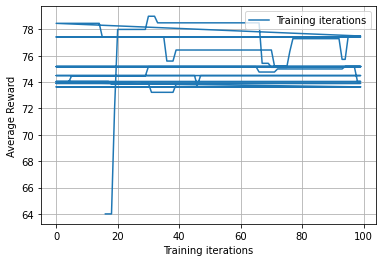

In [3]:
import matplotlib.pyplot as plt
plt.plot(num_iterations,avg_rewards, label="Training iterations")
# plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['temp'], label="temporary reward collected")
plt.xlabel("Training iterations")
plt.ylabel("Average Reward")
plt.legend(loc=1)
plt.grid(True)
plt.show()

In [ ]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune
config = PPOConfig()
# Print out some default values.
print(config.clip_param)
# Update the config object.
config.training(lr=tune.grid_search([0.001, 0.0001]), clip_param=0.2)
# Set the config object's env.
config.environment(env=LightEnvWrapper)
# Use to_dict() to get the old-style python config dict
# when running with tune.
tune.run(
    "PPO",
    stop={"episode_reward_mean": 80},
    config=config.to_dict(),
)

In [ ]:
# Import the RL algorithm (Algorithm) we would like to use.
import ray.rllib.agents.ppo.ppo as ppo


config = ppo.DEFAULT_CONFIG.copy()
config["preprocessor_pref"] = "rllib"
config["framework"] = "torch"
# config["dueling"] = False
# config["double_q"] = False
config["env"] = LightEnvWrapper
# config["env_config"] = { "size_env": 15}
config["model"] = { "fcnet_hiddens": [64, 64],
                    "fcnet_activation": "relu",
    }
# Configure the algorithm.
# config = {
#     # Environment (RLlib understands openAI gym registered strings).
#     "env":LightEnvWrapper,
#     # Use 2 environment workers (aka "rollout workers") that parallelly
#     # collect samples from their own environment clone(s).
#     "num_workers": 2,
#     # Change this to "framework: torch", if you are using PyTorch.
#     # Also, use "framework: tf2" for tf2.x eager execution.
#     "framework": "tf",
#     # Tweak the default model provided automatically by RLlib,
#     # given the environment's observation- and action spaces.
#     "model": {
#         "fcnet_hiddens": [64, 64],
#         "fcnet_activation": "relu",
#     },
#     # Set up a separate evaluation worker set for the
#     # `algo.evaluate()` call after training (see below).
#     "evaluation_num_workers": 1,
#     # Only for evaluation runs, render the env.
#     "evaluation_config": {
#         "render_env": True,
#     },
# }

# Create our RLlib Trainer.
# algo = PPO(config=config)
trainer = ppo.PPOTrainer(config=config)


# Run it for n training iterations. A training iteration includes
# parallel sample collection by the environment workers as well as
# loss calculation on the collected batch and a model update.
for _ in range(3):
    print(trainer.train())

# Evaluate the trained Trainer (and render each timestep to the shell's
# output).
trainer.evaluate()


In [ ]:
# import os
# os.environ["ARCADE_HEADLESS"] = "true"
# import arcade

# class App(arcade.Window):

#     def __init__(self):
#         super().__init__(200, 200)
#         self.frame = 0
#         self.sprite = arcade.Sprite(
#             ":resources:images/animated_characters/female_adventurer/femaleAdventurer_idle.png",
#             center_x=self.width / 2,
#             center_y=self.height / 2,
#         )

#     def on_draw(self):
#         self.clear()
#         self.sprite.draw()

#         # Dump the window framebuffer to disk
#         image = arcade.get_image(0, 0, *self.get_size())
#         image.save("framebuffer.png")

#     def on_update(self, delta_time: float):
#         # Close the window on the second frame
#         if self.frame == 2:
#             self.close()

#         self.frame += 1

# App().run()

In [ ]:
# obs_mygame = LightEnvWrapper.reset
# print(obs_mygame)

In [ ]:
# # importing image class from PIL package
# from PIL import Image
  
# # creating image object
# obs_test = LightEnvWrapper.reset
# print(obs_test)
# img = Image.open(obs_test)
  
# # using convert method for img1
# img1 = img.convert("L")
# img1.show()
  
# # using convert method for img2
# img2 = img.convert("1")
# img2.show()

In [ ]:
# # path2img = r"C:\Users\Tim\OneDrive\Documents\Artificial Intelligence\INM363 Individual Project\GitHub\INM363-Project\Scripts"
# img = Image.open(r"C:\Users\Tim\OneDrive\Documents\Artificial Intelligence\INM363 Individual Project\GitHub\INM363-Project\Scripts\screenshot.png")
# print(img.size)
# # print(img)
# img2 = img.resize((80,60))
# # print(img2)
# # img2.size
# # img2.show()

### Example custom wrapper from ray documentation

In [ ]:
class SimpleCorridor(gym.Env):
    """Example of a custom env in which you have to walk down a corridor.
    You can configure the length of the corridor via the env config."""

    def __init__(self, config: EnvContext):
        self.end_pos = config["corridor_length"]
        self.cur_pos = 0
        self.action_space = Discrete(2)
        self.observation_space = Box(0.0, self.end_pos, shape=(1,), dtype=np.float32)
        # Set the seed. This is only used for the final (reach goal) reward.
        self.seed(config.worker_index * config.num_workers)

    def reset(self):
        self.cur_pos = 0
        return [self.cur_pos]

    def step(self, action):
        assert action in [0, 1], action
        if action == 0 and self.cur_pos > 0:
            self.cur_pos -= 1
        elif action == 1:
            self.cur_pos += 1
        done = self.cur_pos >= self.end_pos
        # Produce a random reward when we reach the goal.
        return [self.cur_pos], random.random() * 2 if done else -0.1, done, {}

    def seed(self, seed=None):
        random.seed(seed)


I will need to install EGL 
and for arcade 2.6.13.